<a href="https://colab.research.google.com/github/LeonardoMonchieri/FL_TinyML/blob/main/IDL_A1_2_downsapmling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install/Import library

In [4]:
!pip install keras-tuner --upgrade

In [5]:
import tensorflow as tf
import keras
import keras_tuner
from keras.utils import to_categorical
from keras.layers import Conv2D, MaxPooling2D,  MaxPool2D
from keras.layers import Flatten, Dense, Dropout, LeakyReLU, Activation
from keras.models import Sequential
from keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import BatchNormalization


# Data

In [3]:
import numpy as np
from sklearn import utils

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

labels = np.load("/content/drive/My Drive/data/labels.npy")
images = np.load("/content/drive/My Drive/data/images.npy")

Mounted at /content/drive


In [4]:
#Shuffle the data
randomize = np.arange(len(images))

np.random.shuffle(randomize)

images = images[randomize]
labels = labels[randomize]

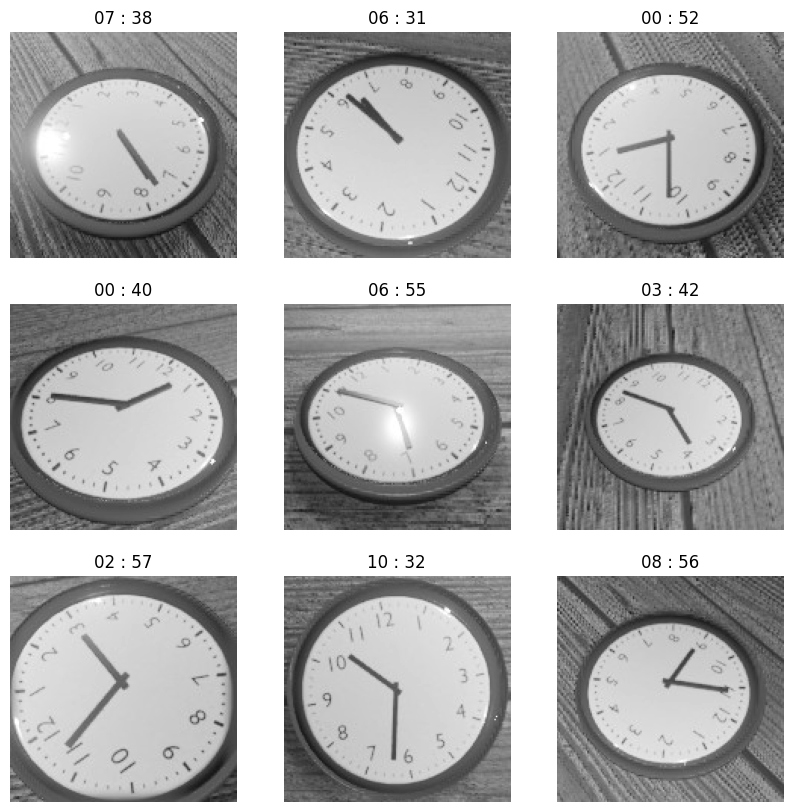

In [5]:
#Randomly check the samples

import matplotlib.pyplot as plt
import random

fig, ax = plt.subplots(3, 3)

fig.set_figheight(10)
fig.set_figwidth(10)

for i in range(3):
  for j in range(3):
    index = random.randint(0, len(images))
    title = "%02d : %02d" % (labels[index][0], labels[index][1] )
    ax[i][j].imshow(images[index], cmap='gray', vmin=0, vmax=255)
    ax[i][j].set_title(title)
    ax[i][j].axis('off')



plt.show()


In [6]:
#Downsample

# from skimage.measure import block_reduce

# images_scaled = block_reduce(images, block_size=(1, 2, 2), func=np.mean)

# print(np.shape(images_scaled))

In [7]:
#Check downsampled images
# fig, ax = plt.subplots(3, 3)

# fig.set_figheight(10)
# fig.set_figwidth(10)

# for i in range(3):
#   for j in range(3):
#     index = random.randint(0, len(images_scaled))
#     title = "%02d : %02d" % (labels[index][0], labels[index][1] )
#     ax[i][j].imshow(images_scaled[index], cmap='gray', vmin=0, vmax=255)
#     ax[i][j].set_title(title)
#     ax[i][j].axis('off')

In [8]:
TRAIN_SIZE = int(images.shape[0]*0.8) #set the train sieze to 80% of the entire ds

valid_images, train_images = images[TRAIN_SIZE:]/255.0, images[:TRAIN_SIZE]/255.0
valid_labels, train_labels = labels[TRAIN_SIZE:], labels[:TRAIN_SIZE]

print("images train set: " +str(np.shape(train_images)[0]))
print("images validation set: "+str(np.shape(valid_images)[0]))
print("Input shape: "+ str(np.shape(train_images)[1:]))

images train set: 14400
images validation set: 3600
Input shape: (150, 150)


# Classification problem



In [3]:
#Classification

#preprocess the data
def classLabel(time):
    """This function compute the new labels, given a time in format [hh, mm] will cut the mm part returning
    a label from 0 to 23 """
    hh = time[0]
    mm = time[1]
    if(mm<=30): return hh*2
    else: return hh*2+1



class_labels = np.array([classLabel(t) for t in labels])
valid_class_labels, train_class_labels = class_labels[TRAIN_SIZE:], class_labels[:TRAIN_SIZE]

print("label train set: " +str(np.shape(train_images)[0]))
print("label validation set: "+str(np.shape(valid_images)[0]))

NameError: ignored

In [ ]:
#Define a custom accuracy method
def time_metric_acc(y_true, y_pred):

  print(tf.shape(y_true))
  print(tf.shape(y_pred))

  # Calculate ((t1 - t2) % 24)
  module_1 = tf.math.floormod(y_true - y_pred, 24)


  # Calculate ((t1 - t1) % 24)
  module_2 = tf.math.floormod(y_pred - y_true, 24)


  # Compute min((t1 - t2) % 24, (t1 - t1) % 24)
  min_module = tf.minimum(module_1, module_2)
  # Print or use the resulting tensor

  total = tf.shape(min_module)[0]
  error = tf.math.count_nonzero(min_module)
  correct = tf.subtract(total, tf.get_static_value(error))

  return correct


# Custom Loss Function considering label intervals
def custom_interval_categorical_crossentropy(y_true, y_pred):
  # Calculate ((t1 - t2) % 24)

  print(tf.shape(y_true))
  print(tf.shape(y_pred))
  module_1 = tf.math.floormod(y_true - y_pred, 24)

  # Calculate ((t1 - t1) % 24)
  module_2 = tf.math.floormod(y_pred - y_true, 24)

  # Compute min((t1 - t2) % 24, (t1 - t1) % 24)
  min_module = tf.minimum(module_1, module_2)

  # Print or use the resulting tensor
  return tf.math.reduce_mean(min_module)/11

t1 = tf.random.uniform((10,1),0,24)
t2 = tf.random.uniform((10,1),0,24)

print(time_metric_acc(t1,t2))

tf.Tensor([10  1], shape=(2,), dtype=int32)
tf.Tensor([10  1], shape=(2,), dtype=int32)
tf.Tensor(0, shape=(), dtype=int32)


In [10]:
#Model
def create_model():
  model = Sequential()

  # Convolutional layers
  model.add(Conv2D(32, (3, 3),strides = 1, activation='relu', input_shape=(150, 150, 1)))
  model.add(Conv2D(32, (3, 3), strides = 1, activation='relu'))
  model.add(MaxPooling2D((3, 3), strides = 2))
  model.add(BatchNormalization())


  model.add(Conv2D(64, (3, 3), strides = 1, activation='relu'))
  model.add(Conv2D(64, (3, 3), strides = 1, activation='relu'))
  model.add(MaxPooling2D((2, 2), strides = 1))
  model.add(BatchNormalization())

  model.add(Conv2D(128, (3, 3), strides = 1, activation='relu'))
  model.add(Conv2D(128, (3, 3), strides = 1, activation='relu'))
  model.add(MaxPooling2D((2, 2), strides = 1))
  model.add(BatchNormalization())


  # Flatten the output and add Dense layers
  model.add(Flatten())

  model.add(Dropout(0.5))
  model.add(Dense(512, activation='relu'))

  # model.add(Dense(64, activation='relu'))
  # model.add(Dropout(0.5))
  model.add(Dense(24, activation='softmax'))  # Output layer with 24 units for 24 labels, using softmax activation

  return model


model = create_model();

In [11]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 147, 147, 32)      0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 147, 147, 32)      128       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 145, 145, 32)      9248      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 144, 144, 32)      0         
 g2D)                                                            
                                                        

In [12]:
optimizer = Adam(learning_rate=0.001)
stop = keras.callbacks.EarlyStopping(monitor = "val_loss", patience = 3, mode = 'min')
model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics = ["accuracy"])

In [ ]:
history = model.fit(train_images, train_class_labels, epochs=35, validation_data=(valid_images, valid_class_labels),
                       #verbose=2,
                       callbacks=[stop])

Epoch 1/35


In [ ]:
#building classification CNN model
def build_model_CNN(hp):
  model = keras.models.Sequential()

  activation = hp.Choice('activation1', ['relu'])
  n_filters = hp.Int('filters', min_value = 32 , max_value = 256, step = 32)
  size = hp.Int('size', min_value = 2, max_value = 3)
  strides = hp.Int('size', min_value = 1, max_value = 2)
  model.add(keras.layers.Conv2D(filters = n_filters, kernel_size = size, strides = 1, padding = 'same', activation = activation, input_shape = [150,150,1]))
  model.add(keras.layers.MaxPooling2D(2))


  n_layers = hp.Int('layers', min_value = 0, max_value = 2)
  size1 = hp.Int('size1', min_value = 2, max_value = 3)
  n_filters = 2*n_filters
  for layer in range(n_layers):
    model.add(Conv2D(filters = n_filters, kernel_size = size, strides = 1, padding = 'same', activation = activation))
    #model.add(keras.layers.Conv2D(filters = n_filters, kernel_size = size, strides = 1, padding = 'same', activation = activation))
    model.add(MaxPooling2D(2))
    model.add(BatchNormalization())
    model.add(Dropout(hp.Choice(f'Dropout{layer}', [0.0, 0.6, 0.1])))
    n_filters = 2*n_filters

  model.add(keras.layers.Flatten())

  n_layers1 = hp.Int('layers1', min_value = 0, max_value = 1)
  max_value = n_filters
  for layer in range(n_layers1):
      units = hp.Int(f'units{layer}', min_value = 30, max_value = max_value)
      kernel_regularizer = hp.Choice(f'regularizer{layer}', ['None', 'l1', 'l2', 'l12'])
      model.add(Dense(units, activation, kernel_regularizer))
      model.add(BatchNormalization())
      model.add(Dropout(hp.Choice(f'Dropout1.{layer}', [0.0, 0.6, 0.1])))
      max_value = units

  activation1 = hp.Choice('activation1', ['softmax'])
  model.add(keras.layers.Dense(24, activation1))
  optimizer = keras.optimizers.SGD(learning_rate = hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4]))
  model.compile(loss = 'sparse_categorical_crossentropy', optimizer = optimizer, metrics = ['accuracy'])

  model.summary();

  return model

In [ ]:
tuner_CNN = keras_tuner.RandomSearch(hypermodel = build_model_CNN, objective = 'val_accuracy', overwrite = True, directory = r'\\wsl.localhost\Ubuntu-22.04\home\juliapessers\IDL', project_name = 'Tuner_CNN')
stop = keras.callbacks.EarlyStopping(monitor = 'val_accuracy', patience = 3, mode = 'max')

tuner_CNN.search(train_images, train_class_labels, epochs = 35, validation_split = 0.1, callbacks = [stop])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 150, 150, 32)      160       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 75, 75, 32)        0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 180000)            0         
                                                                 
 dense_1 (Dense)             (None, 24)                4320024   
                                                                 
Total params: 4320184 (16.48 MB)
Trainable params: 4320184 (16.48 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________

Search: Running Trial #1

Value             |Best Value So Far |Hyperparameter


KeyboardInterrupt: ignored

In [ ]:
#Compile the model
optimizer = keras.optimizers.SGD(learning_rate = hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4]))
model.compile(loss = 'sparse_categorical_crossentropy', optimizer = optimizer, metrics=["accuracy"])

In [ ]:
def plotHistory(model_history):
  plt.plot(model_history.history['accuracy'], label='accuracy')
  plt.plot(model_history.history['val_accuracy'], label = 'val_accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.ylim([0.5, 1])
  plt.legend(loc='lower right')



In [ ]:
plotHistory(class_history);

# Regression problem

## Regression Label

In [ ]:
#Linear Regression

def regLabel(time):
    """This function compute the new labels for linear regression, given a time in format [hh, mm] will devide and round the mm part returning
    a label in the format hh.(mm/60)"""
    hh = time[0]
    mm = time[1]
    return hh+ round(mm/60,2)



reg_labels = np.array([regLabel(t) for t in labels])

valid_reg_labels, train_reg_labels = reg_labels[:TRAIN_SIZE], reg_labels[TRAIN_SIZE:]

## Model

In [ ]:
#building classification CNN model
def build_model_CNN(hp):
  model = keras.models.Sequential()

  activation = "relu"
  n_filters = hp.Int('filters', min_value = 64 , max_value = 76, step = 32)
  size = hp.Int('size', min_value = 7, max_value = 9)

  #Input layer
  model.add(keras.layers.Conv2D(filters = n_filters, kernel_size = size, strides = 1, padding = 'same', activation = activation, input_shape = [150,150,1]))
  model.add(keras.layers.MaxPooling2D(2))

  #Hidden convolutional layer
  n_layers = hp.Int('layers', min_value = 0, max_value = 1)
  size1 = hp.Int('size1', min_value = 3, max_value = 5)
  n_filters = 2*n_filters
  for layer in range(n_layers):
    model.add(keras.layers.Conv2D(filters = n_filters, kernel_size = size, strides = 1, padding = 'same', activation = activation))
    #model.add(keras.layers.Conv2D(filters = n_filters, kernel_size = size, strides = 1, padding = 'same', activation = activation))
    model.add(keras.layers.MaxPooling2D(2))
    model.add(BatchNormalization())
    model.add(keras.layers.Dropout(hp.Choice(f'Dropout{layer}', [0.0, 0.6, 0.1])))
    n_filters = 2*n_filters

  #Flatten layer
  model.add(keras.layers.Flatten())

  n_layers1 = hp.Int('layers1', min_value = 0, max_value = 1)
  max_value = n_filters
  for layer in range(n_layers1):
      units = hp.Int(f'units{layer}', min_value = 30, max_value = max_value)
      kernel_regularizer = hp.Choice(f'regularizer{layer}', ['None', 'l1', 'l2', 'l12'])
      model.add(keras.layers.Dense(units, activation, kernel_regularizer))
      model.add(BatchNormalization())
      model.add(keras.layers.Dropout(hp.Choice(f'Dropout1.{layer}', [0.0, 0.6, 0.1])))
      max_value = units

  #Output dense layer

  model.add(keras.layers.Dense(1, "linear"))
  optimizer = keras.optimizers.SGD(learning_rate = hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4]))

  model.compile(loss = 'sparse_categorical_crossentropy', optimizer = optimizer, metrics=[time_metric_acc])
  return model



# Muti-haed model

# Label Transforamtion

In [ ]:
#Sin - Cosin Label

def sinCosLabel(time):
    hh = time[0]
    mm = time[1]

    print(hh)
    print(mm)
    mm_sin = np.sin(mm*(2.*np.pi/59))
    mm_cos = np.cos(mm*(2.*np.pi/59))


    hh_sin = np.sin(hh*(2.*np.pi/23))
    hh_cos = np.cos(hh*(2.*np.pi/23))

    new_mm = np.array([mm_sin, mm_cos])
    new_hh = np.array([hh_sin, hh_cos])

    t = np.array([new_hh, new_mm])

    return t